# Configurate Session


In [ ]:
%load_ext autoreload

import os
import sys

project_root = "../repos/Natural-Language"
if project_root not in sys.path:
    sys.path.append(project_root)
os.chdir(project_root)

print("Current working directory:", os.getcwd())

# Load Data


In [2]:
%autoreload 2
from src.dataset import read_data

path = "data/raw/train.txt"
columns = ["title", "from", "genre", "director", "description"]

df = read_data(path, columns)
df.head(3)

,title,from,genre,director,description
0,Ela Cheppanu,Telugu,romance,Ramana,Sekhar (Tarun) is a graduate from IIM and work...
1,A Nightmare on Elm Street,American,horror,Samuel Bayer,Kris Fowles (Katie Cassidy) goes to the Spring...
2,American Gothic,American,horror,John Hough,Cynthia is traumatized by the death of her bab...


# EDA


### First Impressions


In [3]:
%autoreload 2
print(df.info())
print("*" * 20)
repeated_titles = df["title"].value_counts()[df["title"].value_counts() > 1].head(5)
print(repeated_titles)
print("*" * 20)
popular_directors = df["director"].value_counts().head(5)
print(popular_directors)
print("*" * 20)
print(df["from"].value_counts().head(5))
print("*" * 20)
print(df["genre"].value_counts())
print("*" * 20)
print("Number of duplicates:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8041 entries, 0 to 8040
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        8041 non-null   object
 1   from         8041 non-null   object
 2   genre        8041 non-null   object
 3   director     8041 non-null   object
 4   description  8041 non-null   object
dtypes: object(5)
memory usage: 314.2+ KB
None
********************
title
Dracula               4
The Crimson Circle    3
Hindle Wakes          3
Romance               3
I Love You            3
Name: count, dtype: int64
********************
director
Unknown            178
Hanna-Barbera       46
Lesley Selander     32
Maurice Elvey       28
Joseph Kane         23
Name: count, dtype: int64
********************
from
American     4050
British      1415
Bollywood     632
Telugu        276
Tamil         261
Name: count, dtype: int64
********************
genre
drama        1676
comedy       1193
horror     

### Drop Duplicates


In [4]:
df[df.duplicated(keep=False)].sort_values("title").head(6)

,title,from,genre,director,description
7102,At Gunpoint,American,western,Alfred L. Werker,"Plainview is a peaceful town, all the better f..."
4053,At Gunpoint,American,western,Alfred L. Werker,"Plainview is a peaceful town, all the better f..."
3121,Black Rock,American,horror,Katie Aselton,Sarah (Kate Bosworth) invites her childhood fr...
4714,Black Rock,American,horror,Katie Aselton,Sarah (Kate Bosworth) invites her childhood fr...
6456,Captain America,American,action,Albert Pyun,"In Fascist Italy in 1936, the government kidna..."
6285,Captain America,American,action,Albert Pyun,"In Fascist Italy in 1936, the government kidna..."


In [5]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

### Plots


In [6]:
%autoreload 2

from src.plots import (
    plot_movie_data,
    plot_stopword_frequency,
    get_text_statistics,
    plot_histograms,
    plot_boxplots,
    plot_pca_tfidf,
    plot_correlation_matrix,
    plot_pca,
)

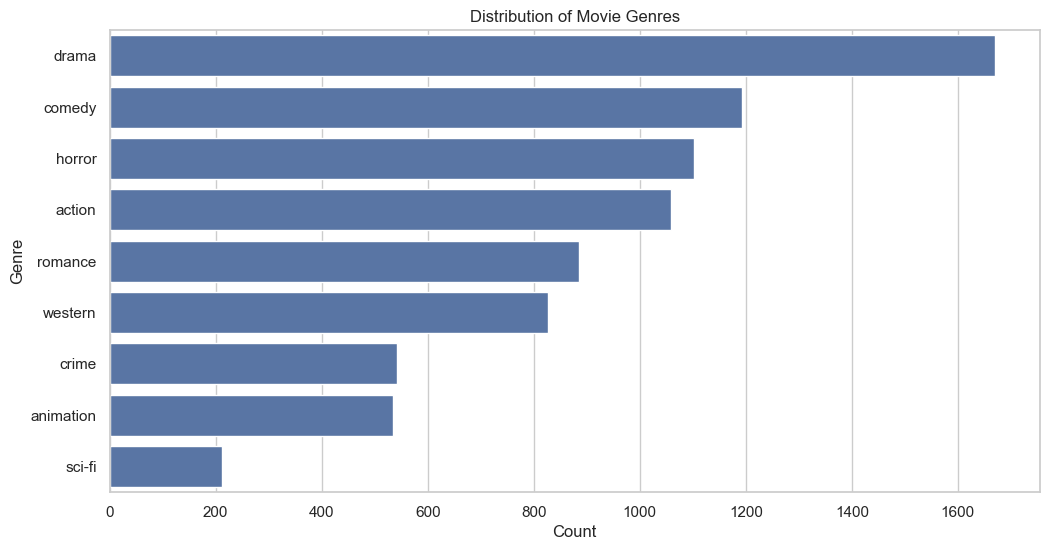

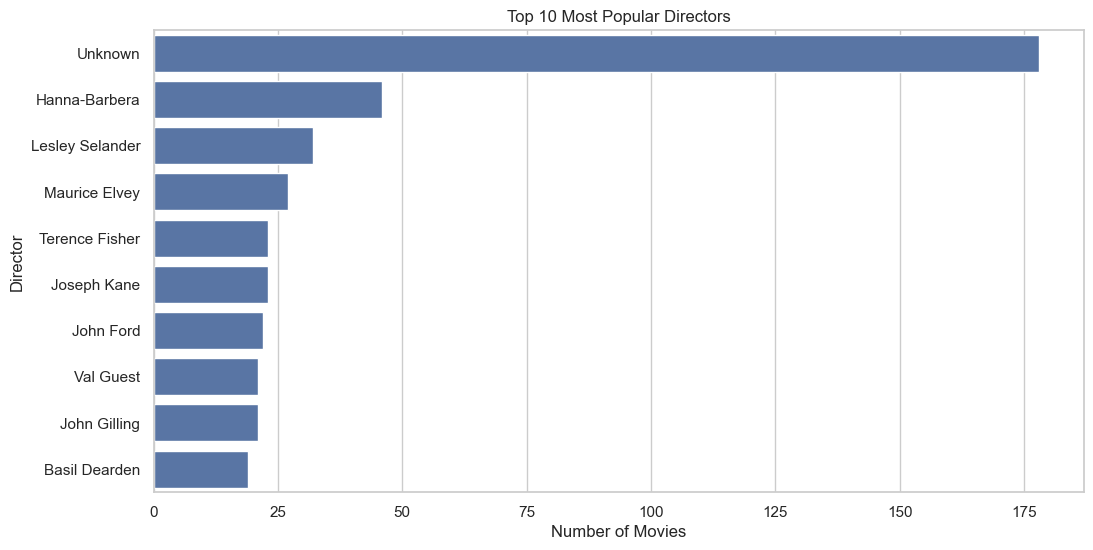

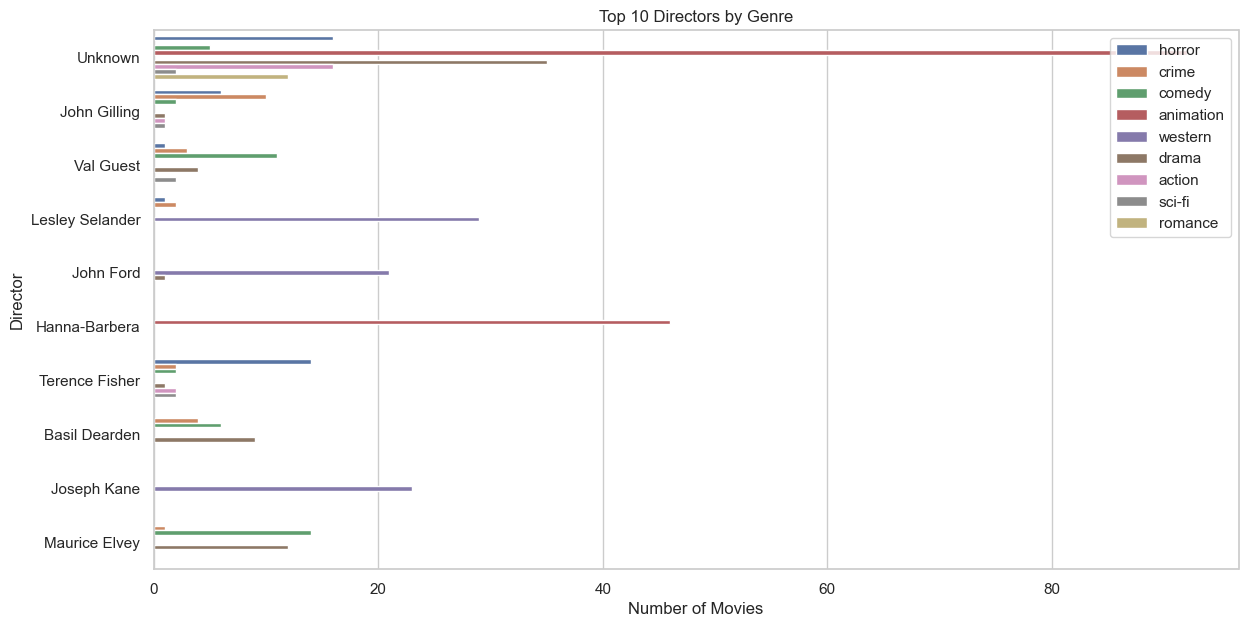

In [7]:
plot_movie_data(df)

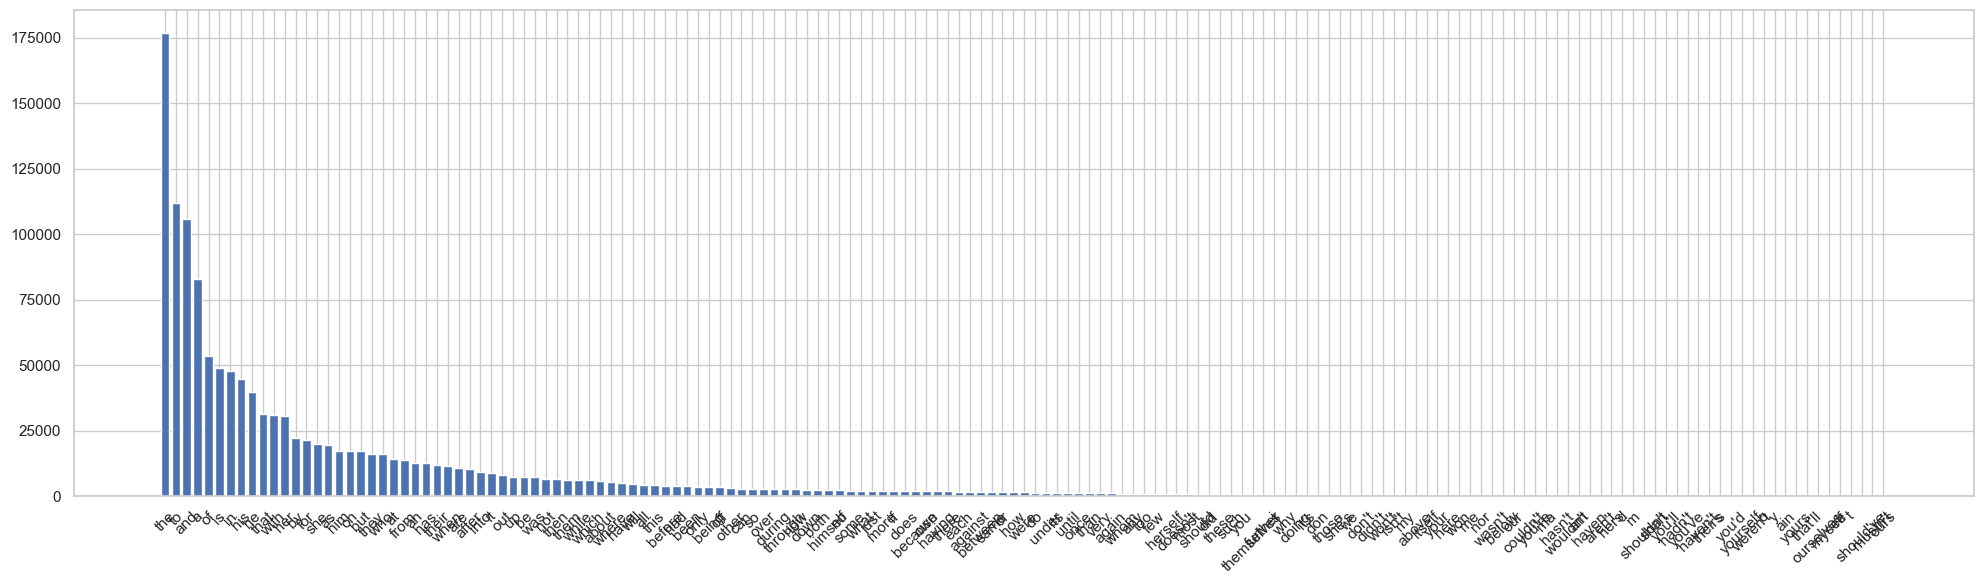

In [8]:
plot_stopword_frequency(df, "description")

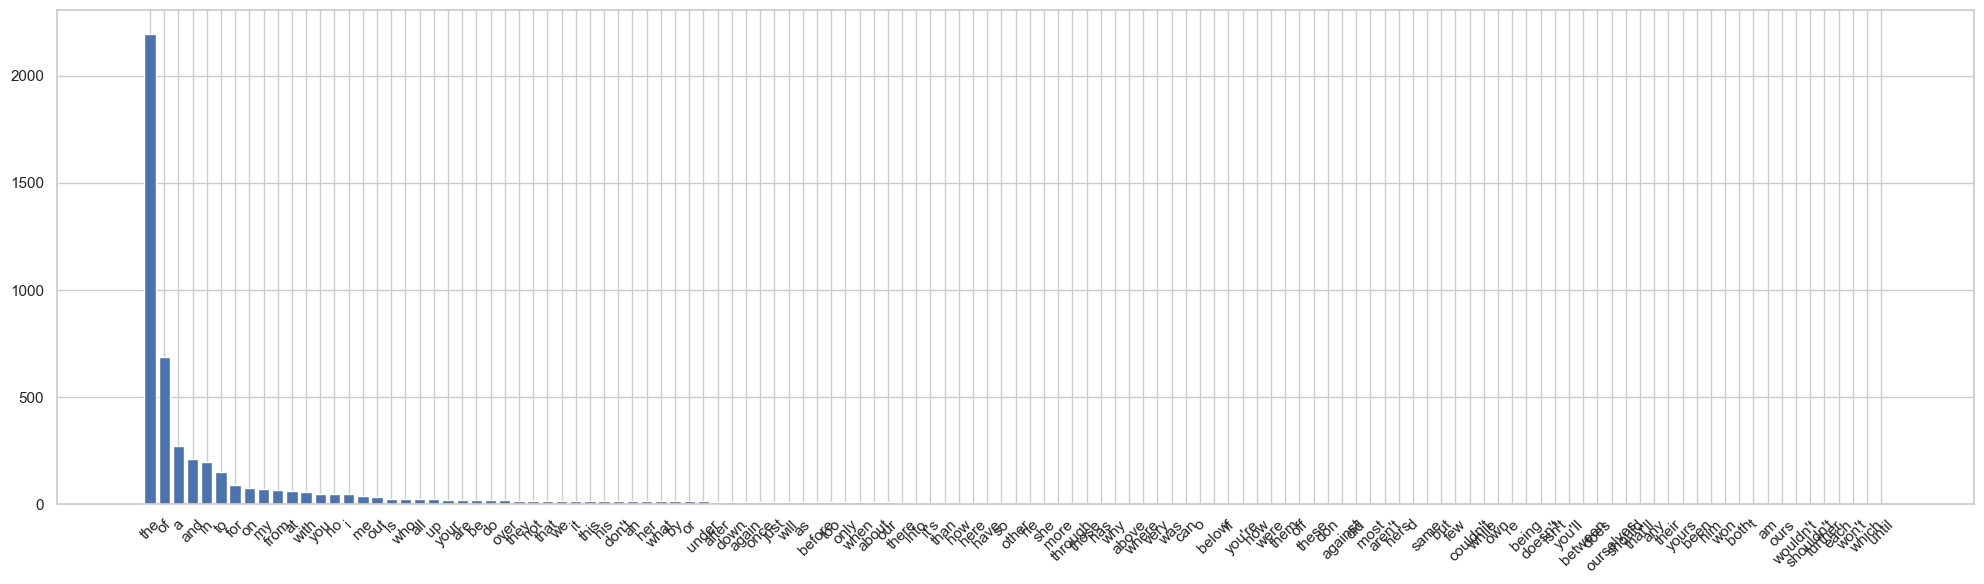

In [9]:
plot_stopword_frequency(df, "title")

In [10]:
stats = get_text_statistics(df, "description")

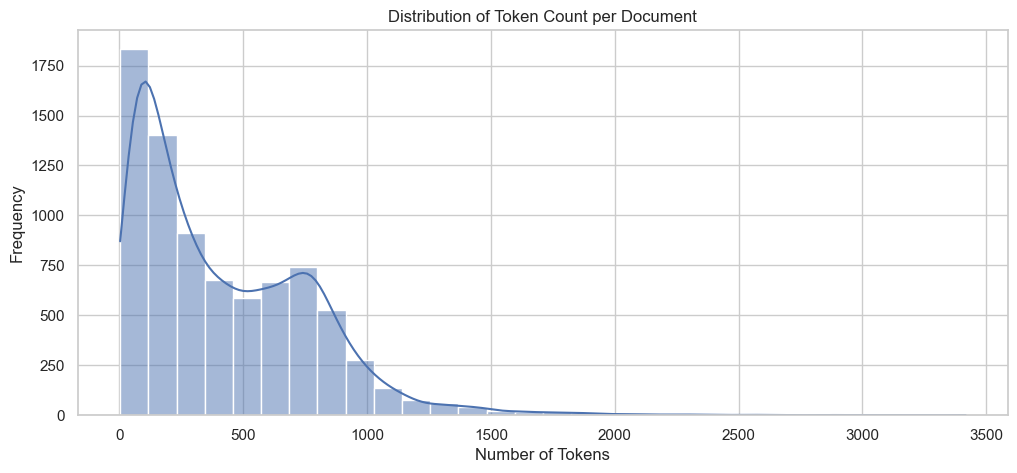

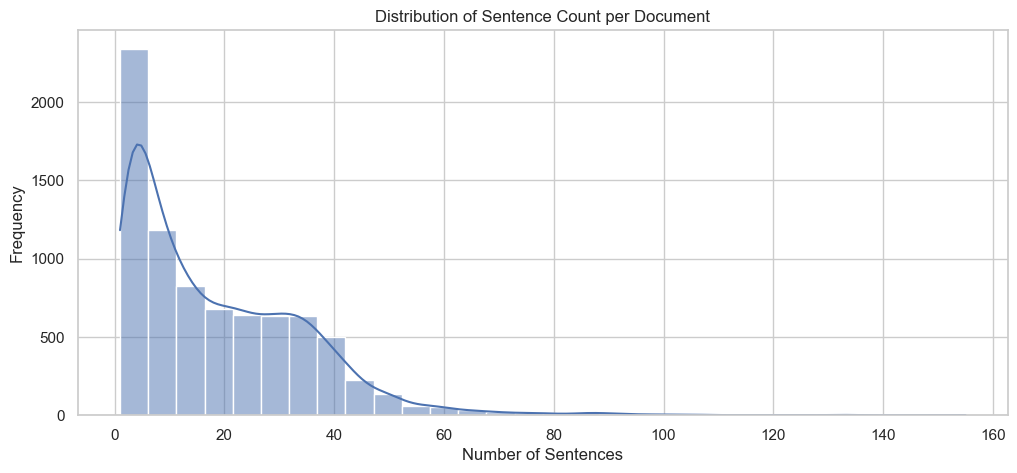

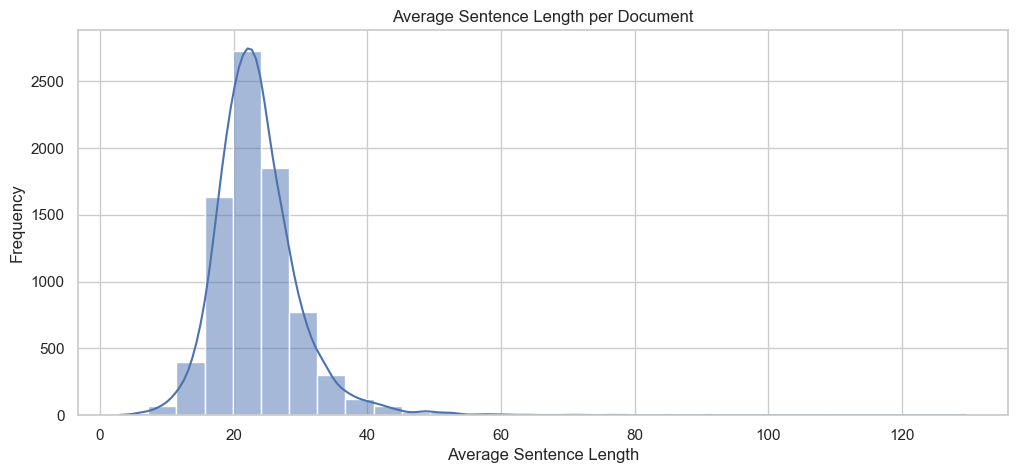

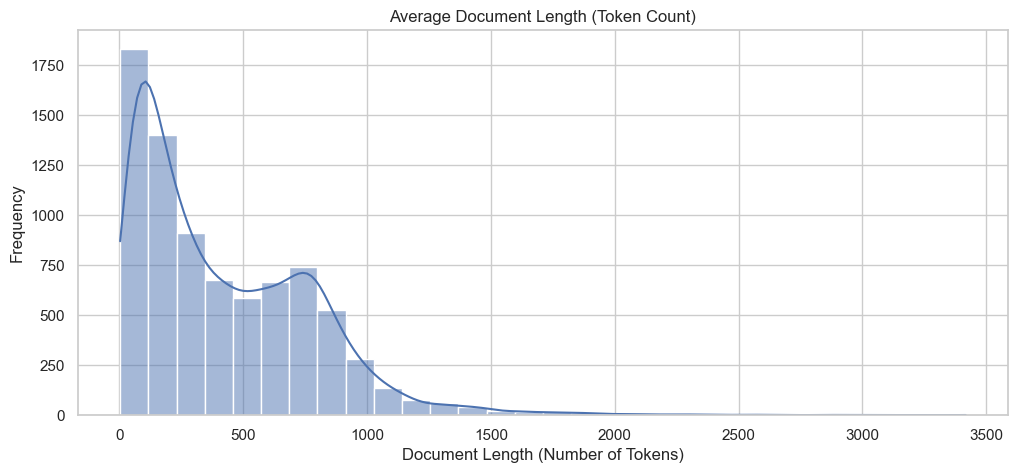

In [11]:
plot_histograms(stats)

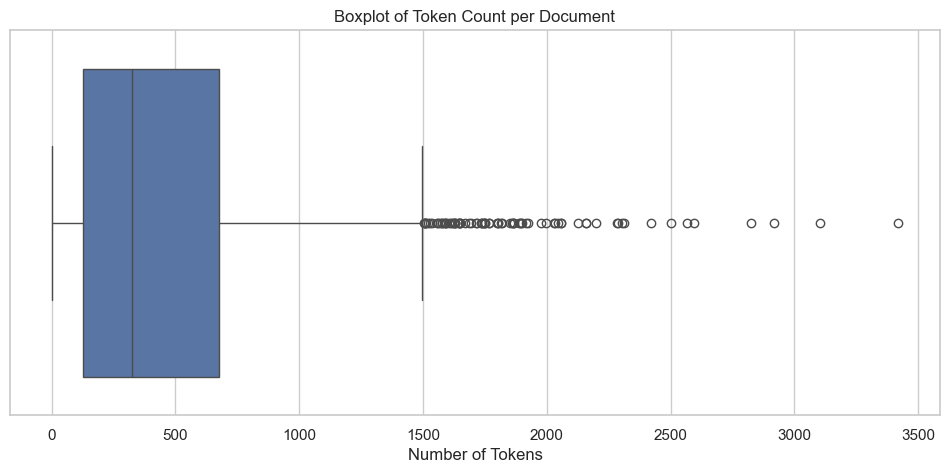

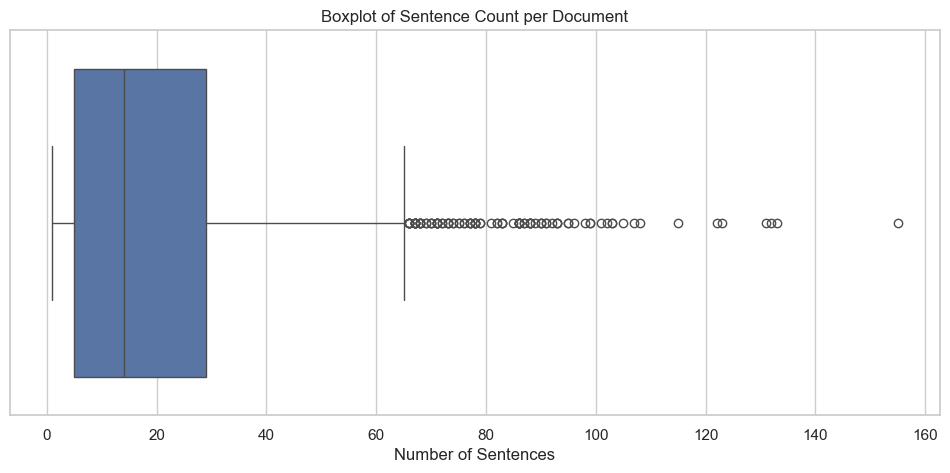

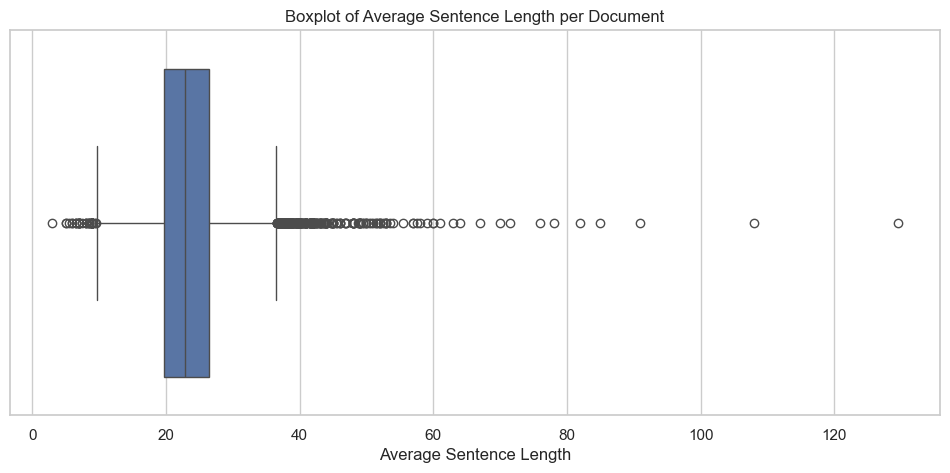

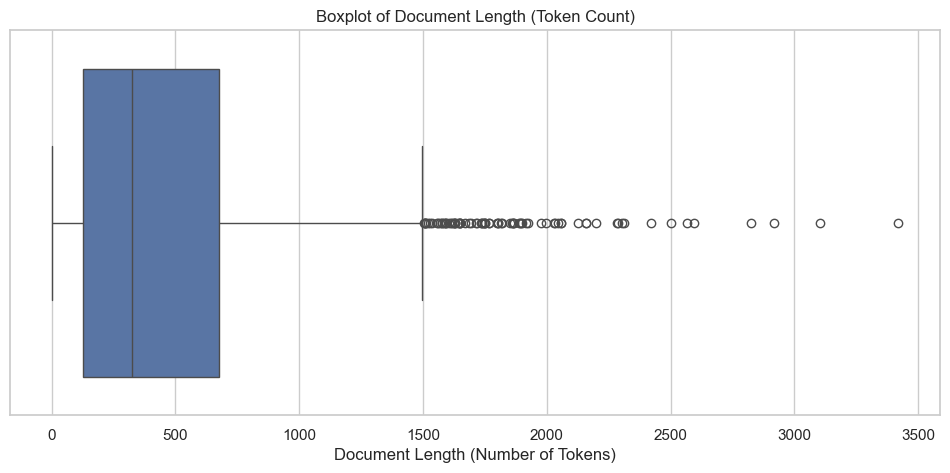

In [12]:
plot_boxplots(stats)

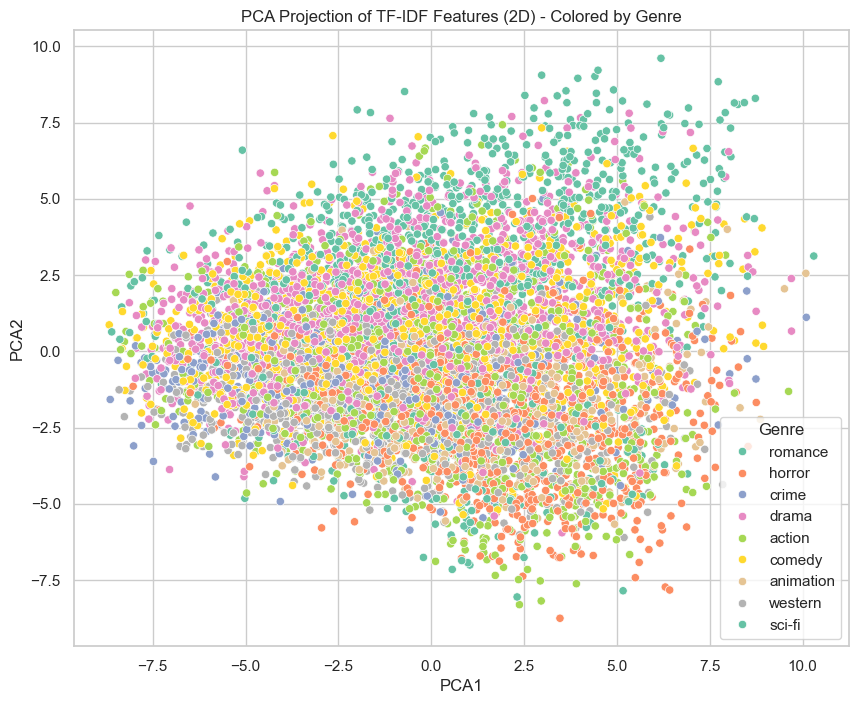

In [13]:
pca_description_df, pca_description = plot_pca_tfidf(df, "description", "genre")

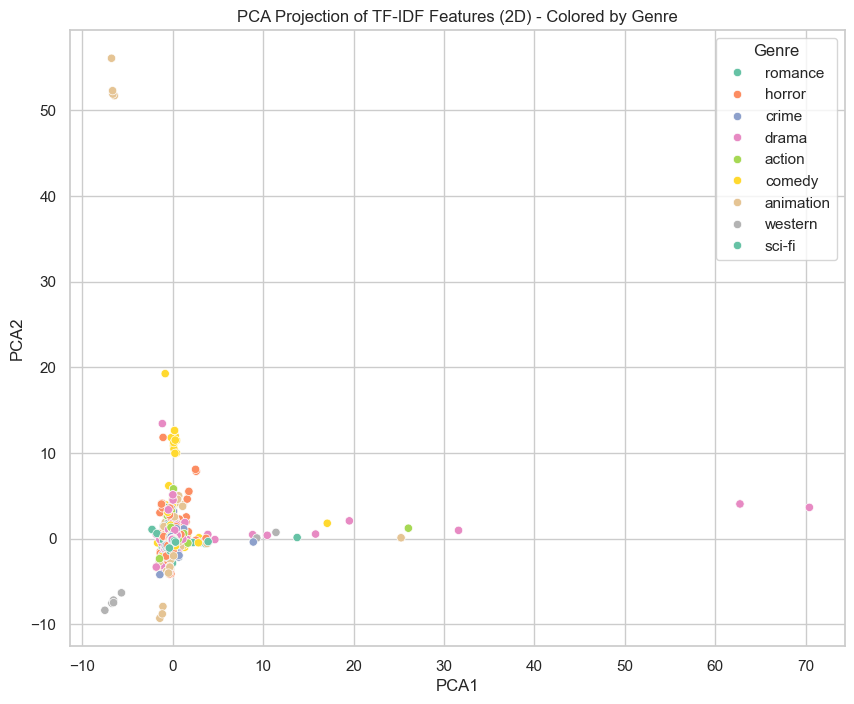

In [14]:
pca_title_df, pca_title = plot_pca_tfidf(df, "title", "genre")

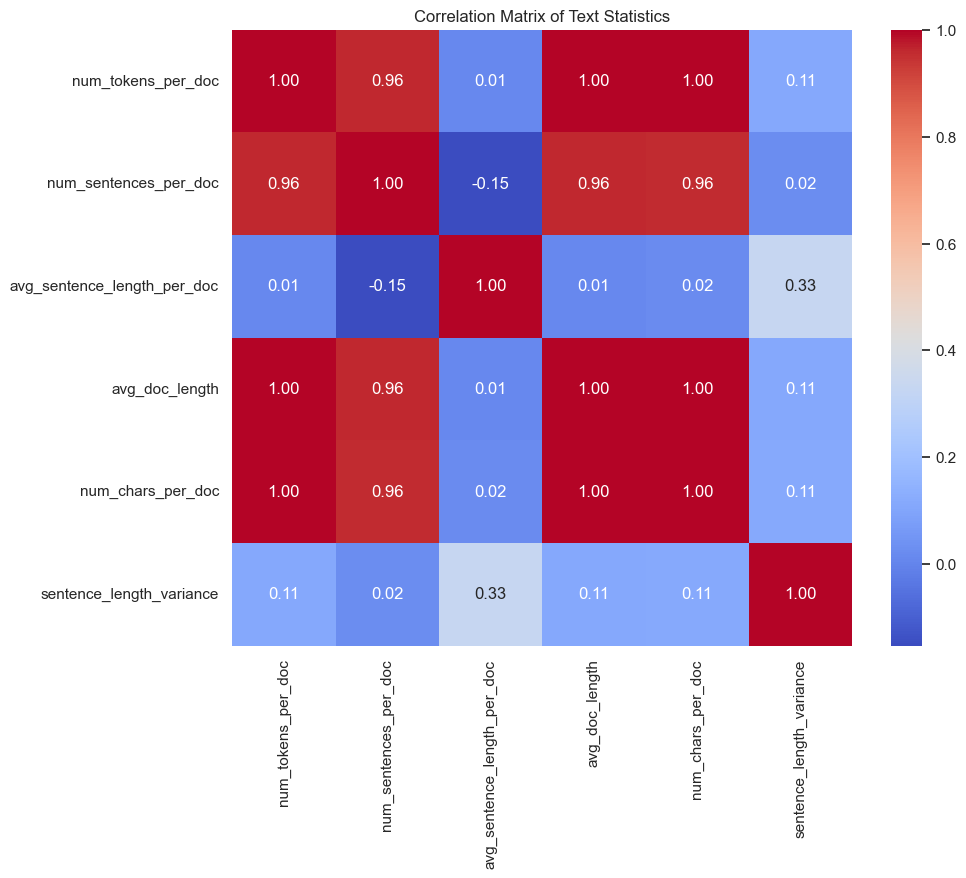

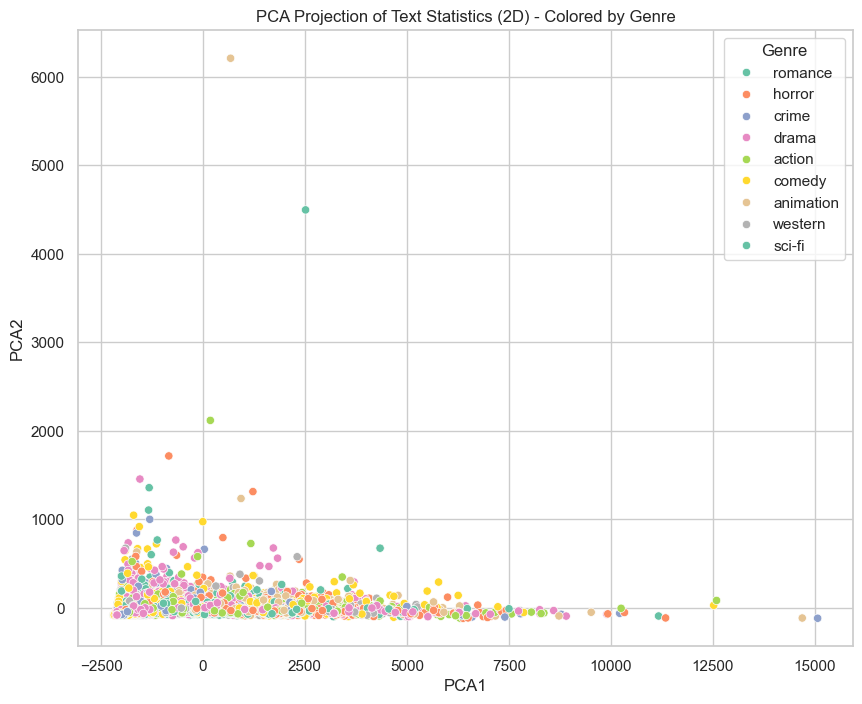

In [15]:
plot_correlation_matrix(stats)
pca_stats_df, pca_stats = plot_pca(stats, df["genre"])

# Duplicate Candidates 

In [17]:
%autoreload 2

from src.director_encoder import (
    filter_duplicate_descriptions,
    find_similar_descriptions,
    print_differences,
)

In [19]:
filter_duplicate_descriptions(df, "description", "title").head(6)

,title,from,genre,director,description
5741,Black Dalia,Malayalam,action,Baburaj,A student of Sacred Heart Medical College is f...
4028,Anthima Theerpu,Telugu,action,A.D.V. Babu Raj,A student of Sacred Heart Medical College is f...
435,Bhayya,Telugu,action,Boopathy Pandian,Anbu (Vishal) is a happy-go-lucky engineering ...
7419,Malaikottai,Tamil,action,Boopathy Pandian,Anbu (Vishal) is a happy-go-lucky engineering ...
3026,The Protector,Hong Kong,action,James Glickenhaus,"As noted above, Jackie Chan re-edited The Prot..."
7693,"Protector, The",American,action,James Glickenhaus,"As noted above, Jackie Chan re-edited The Prot..."


In [20]:
similar_pairs = find_similar_descriptions(df, "description")

In [21]:
print_differences(df, similar_pairs, "title")
print("\n")
print_differences(df, similar_pairs, "director")
print("\n")
print_differences(df, similar_pairs, "genre")
print("\n")
print_differences(df, similar_pairs, "from")


 Different Title: 

Neevalle Neevalle (95) and Unnale Unnale (1641) : (Cosine 1.0000, Jaccard 1.0000)
Bhayya (435) and Malaikottai (7419) : (Cosine 1.0000, Jaccard 1.0000)
Little Big Horn (819) and The Fighting Seventh (1009) : (Cosine 1.0000, Jaccard 1.0000)
In Old Oklahoma (1043) and War of the Wildcats (4839) : (Cosine 1.0000, Jaccard 1.0000)
The Final Conflict (1056) and Omen III: The Final Conflict (2826) : (Cosine 1.0000, Jaccard 1.0000)
Yaar Ivan (1368) and Veedevadu (7830) : (Cosine 1.0000, Jaccard 1.0000)
Harry Tracy, Desperado (1452) and Harry Tracy (6766) : (Cosine 1.0000, Jaccard 1.0000)
Rowthiram (1546) and Roudram (7612) : (Cosine 1.0000, Jaccard 1.0000)
Nayagi (2307) and Nayaki (2316) : (Cosine 1.0000, Jaccard 1.0000)
Mr. Bug Goes to Town (2399) and Mister Bug Goes to Town (5016) : (Cosine 1.0000, Jaccard 1.0000)
Terror Street (2444) and 36 Hours (3036) : (Cosine 1.0000, Jaccard 1.0000)
Vettaikkaran (2464) and Puli Veta (7204) : (Cosine 1.0000, Jaccard 1.0000)
Lakshmi P

# Train-Test Split

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder().fit(df["genre"])
df["genre"] = label_encoder.transform(df["genre"])


train_df, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df["genre"])

In [23]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Generate Embeddings

In [24]:
%autoreload 2

from src.embedding import process_and_save_in_chunks
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("avsolatorio/GIST-small-Embedding-v0")

c:\Users\vasco\repos\Natural-Language\venv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [ ]:
output_path = "data/processed/processed_embeddings_train.csv"
process_and_save_in_chunks(train_df, "description", model, chunk_size=300, output_path=output_path)

In [25]:
import pandas as pd

embedding_train_path = "data/processed/processed_embeddings_train.csv"
embedding_train_df = pd.read_csv(embedding_train_path)

embedding_train_df = pd.concat([train_df["genre"], embedding_train_df], axis=1)
embedding_train_df.drop_duplicates(inplace=True)
embedding_train_df.reset_index(drop=True, inplace=True)
embedding_train_df.head(3)

,genre,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_375,embedding_376,embedding_377,embedding_378,embedding_379,embedding_380,embedding_381,embedding_382,embedding_383,embedding_384
0,2,-0.008617,0.022097,-0.004732,-0.028206,-0.002101,0.019100,0.066881,-0.003675,-0.001129,...,0.033189,-0.037922,-0.007553,-0.045302,0.010430,0.008653,-0.020419,0.035640,0.036762,0.029850
1,0,-0.051309,0.045128,-0.023196,-0.045813,0.009651,0.000577,0.094067,-0.025615,-0.005722,...,0.017055,-0.033458,0.003634,0.079151,0.056169,-0.033074,0.025772,-0.005815,0.014292,0.006896
2,1,-0.066860,-0.019683,0.022432,-0.019122,0.016281,0.010957,0.092053,0.068600,-0.022483,...,0.052965,-0.045983,-0.014270,-0.018857,-0.028362,0.003386,-0.020476,0.035824,-0.012908,-0.001963


In [ ]:
output_path = "data/processed/processed_embeddings_test.csv"
process_and_save_in_chunks(test_df, "description", model, chunk_size=300, output_path=output_path)

In [49]:
embedding_test_path = "data/processed/processed_embeddings_test.csv"
embedding_test_df = pd.read_csv(embedding_test_path)

embedding_test_df = pd.concat([test_df["genre"], embedding_test_df], axis=1)
embedding_test_df.head(3)

,genre,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_375,embedding_376,embedding_377,embedding_378,embedding_379,embedding_380,embedding_381,embedding_382,embedding_383,embedding_384
0,3,-0.037961,-0.010047,0.024646,-0.062221,0.037619,-0.007261,0.080556,0.017303,-0.032102,...,0.026059,-0.035682,0.001861,0.014797,0.031231,-0.017260,-0.008786,0.016725,0.022522,0.014918
1,4,-0.048284,0.016644,-0.009671,-0.032147,0.061349,0.009491,0.069933,-0.021847,-0.024443,...,0.051359,-0.013961,-0.003452,-0.030090,-0.022626,0.024079,-0.000441,0.030043,0.063390,0.021192
2,3,-0.056124,0.007706,0.007324,-0.029381,0.055259,-0.025589,0.095870,-0.028611,0.007656,...,0.010799,-0.027841,0.001584,0.039391,-0.021739,-0.033515,0.029476,-0.012657,0.102413,0.002689


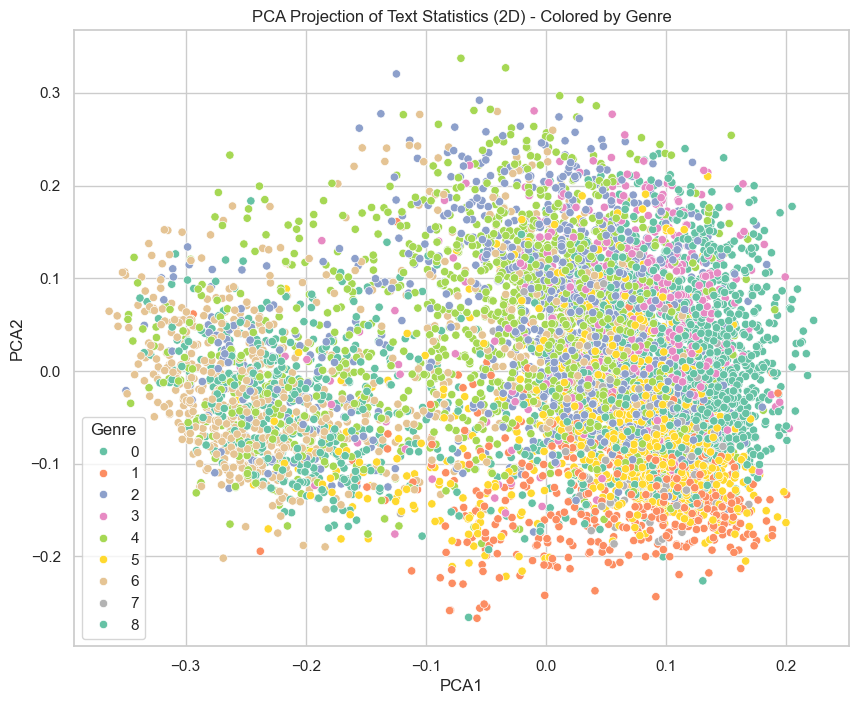

In [27]:
embeddings_aux = embedding_train_df.drop("genre", inplace=False, axis=1)
pca_embedding_df, pca_embedding = plot_pca(embeddings_aux, embedding_train_df["genre"])

# Cleaning Directors


In [28]:
%autoreload 2

from src.director_encoder import encode_directors, get_encoding_map

In [29]:
similar_pairs = find_similar_descriptions(train_df, "description")

In [30]:
mapping = get_encoding_map(train_df, test_df)

In [31]:
train_df = encode_directors(train_df, "train", mapping)
test_df = encode_directors(test_df, "test", mapping)

train_df.drop("director", axis=1, inplace=True)
test_df.drop("director", axis=1, inplace=True)

In [32]:
train_df.drop_duplicates(inplace=True)
train_df.reset_index(drop=True, inplace=True)

# Preprocessing


In [33]:
%autoreload 2

from src.preprocessing import preprocess_sentence

# Expand contractions, extract noun-phrases, tokenize and lemmatize (optionally remove stopwords)
train_df["title"] = train_df["title"].apply(preprocess_sentence)
train_df["description"] = train_df["description"].apply(preprocess_sentence)

test_df["title"] = test_df["title"].apply(preprocess_sentence)
test_df["description"] = test_df["description"].apply(preprocess_sentence)

# Feature Engineering

In [34]:
%autoreload 2

from src.features import REGION_MAP, select_tokens

In [35]:
train_df["region"] = train_df["from"].replace(REGION_MAP)
test_df["region"] = test_df["from"].replace(REGION_MAP)

# Feature Selection (Log Ratio Analysis)


In [38]:
%autoreload 2
from src.logratioanalysis import LogRatioAnalysis, plot_scree_subplots_for_genres

In [39]:
logratio_title = LogRatioAnalysis(train_df, "title", "genre")
logratio_description = LogRatioAnalysis(train_df, "description", "genre")

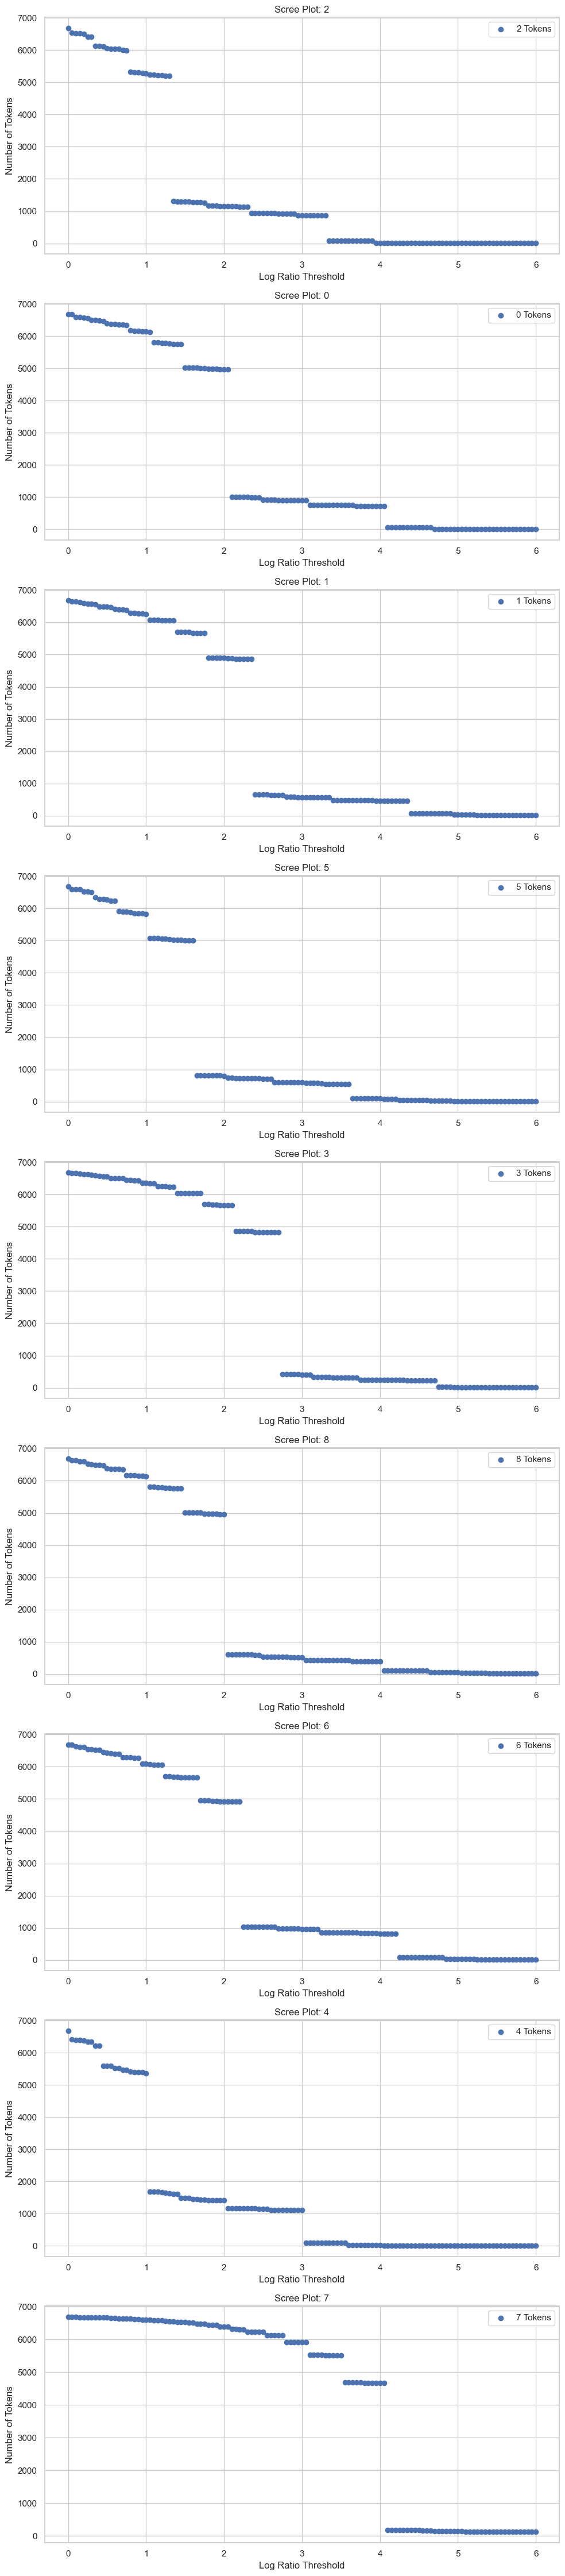

In [40]:
plot_scree_subplots_for_genres(logratio_title)

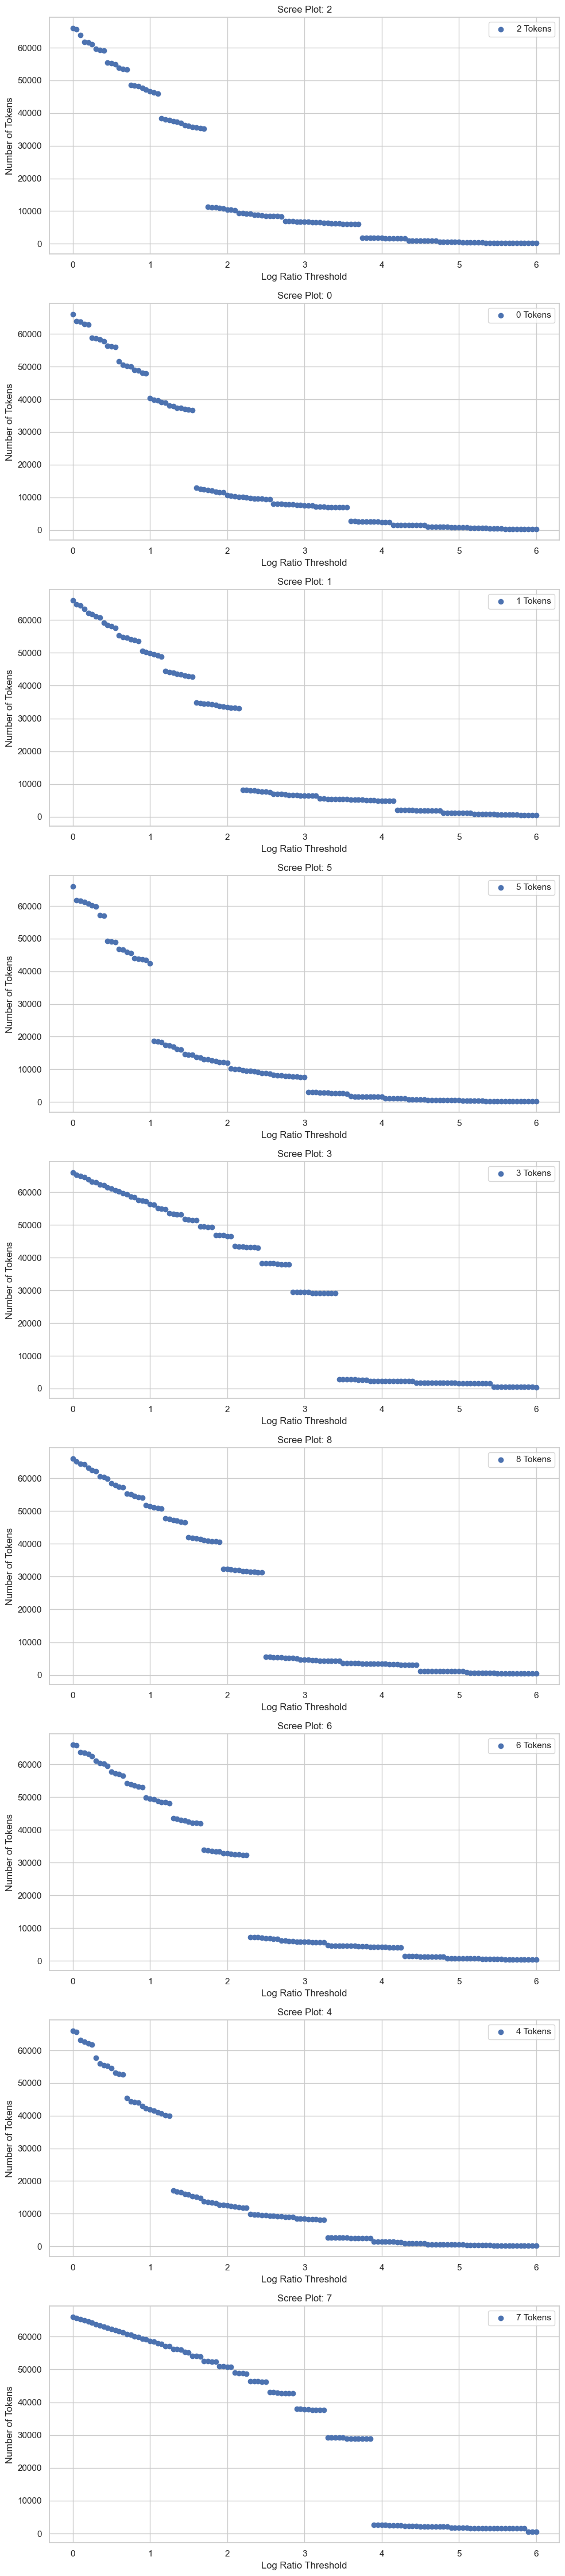

In [41]:
plot_scree_subplots_for_genres(logratio_description)

In [42]:
description_tokens = logratio_description.feature_selection(25000)
title_tokens = logratio_title.feature_selection(1000)

In [43]:
train_df["selected_description"] = train_df["description"].apply(select_tokens, selected_tokens=description_tokens)
test_df["selected_description"] = test_df["description"].apply(select_tokens, selected_tokens=description_tokens)

# Modelling


In [36]:
from mlxtend.feature_selection import ColumnSelector
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
from skrub import SelectCols, SimilarityEncoder
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.plots import plot_confusion_matrix

In [37]:
decoded_class_names = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

In [38]:
X_train = train_df.drop("genre", axis=1)
y_train = train_df["genre"]

In [39]:
X_test = test_df.drop("genre", axis=1)
y_test = test_df["genre"]

In [40]:
X_test["encoded_director"].fillna(min(X_test["encoded_director"]), inplace=True)

### Scenario 1: HistGradientBoostingClassifier w/ SVD

In [49]:
text_pipeline_1 = make_union(
    make_pipeline(
        ColumnSelector("title", drop_axis=True),
        TfidfVectorizer(),
        TruncatedSVD(),
    ),
    make_pipeline(
        ColumnSelector("description", drop_axis=True),
        TfidfVectorizer(),
        TruncatedSVD(),
    ),
    make_pipeline(SelectCols("region"), SimilarityEncoder()),
    make_pipeline(SelectCols("from"), OneHotEncoder(sparse_output=False)),
    make_pipeline(SelectCols("encoded_director")),
)

pipeline_1 = make_pipeline(text_pipeline_1, HistGradientBoostingClassifier())
pipeline_1

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('columnselector',
                                                                  ColumnSelector(cols='title',
                                                                                 drop_axis=True)),
                                                                 ('tfidfvectorizer',
                                                                  TfidfVectorizer()),
                                                                 ('truncatedsvd',
                                                                  TruncatedSVD())])),
                                                ('pipeline-2',
                                                 Pipeline(steps=[('columnselector',
                                                                  ColumnSelector(cols='description',
                                                                                 drop_axis=True)),
                                                                 ('tfidfvectorizer',
                                                                  Tfi...
                                                                  SelectCols(cols='region')),
                                                                 ('similarityencoder',
                                                                  SimilarityEncoder())])),
                                                ('pipeline-4',
                                                 Pipeline(steps=[('selectcols',
                                                                  SelectCols(cols='from')),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(sparse_output=False))])),
                                                ('pipeline-5',
                                                 Pipeline(steps=[('selectcols',
                                                                  SelectCols(cols='encoded_director'))]))])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier())])

In [50]:
param_distributions = {
    "histgradientboostingclassifier__learning_rate": np.logspace(-3, 0, 100),
    "histgradientboostingclassifier__max_iter": np.arange(100, 500, 50),
    "histgradientboostingclassifier__max_depth": np.arange(3, 15),
    "histgradientboostingclassifier__min_samples_leaf": np.arange(1, 51, 5),
    "histgradientboostingclassifier__max_leaf_nodes": np.arange(10, 301, 10),
    "histgradientboostingclassifier__l2_regularization": np.logspace(-4, 0, 100),
    "histgradientboostingclassifier__scoring": ["accuracy"],
    "featureunion__pipeline-1__truncatedsvd__n_components": np.arange(200, 400, 50),
    "featureunion__pipeline-2__truncatedsvd__n_components": np.arange(4000, 6000, 500),
}

In [ ]:
random_search_1 = RandomizedSearchCV(
    pipeline_1,
    param_distributions=param_distributions,
    n_iter=10,
    cv=4,
    scoring="accuracy",
    random_state=42,
    verbose=4,
    error_score="raise",
)
random_search_1.fit(X_train, y_train)

In [ ]:
best_params = random_search_1.best_params_
best_score = random_search_1.best_score_
best_model = random_search_1.best_estimator_

print("\n Best Parameters:", best_params)
print("\n Best Score:", best_score)

In [51]:
best_params = {
    "histgradientboostingclassifier__scoring": "accuracy",
    "histgradientboostingclassifier__min_samples_leaf": np.int64(26),
    "histgradientboostingclassifier__max_leaf_nodes": np.int64(40),
    "histgradientboostingclassifier__max_iter": np.int64(250),
    "histgradientboostingclassifier__max_depth": np.int64(14),
    "histgradientboostingclassifier__learning_rate": np.float64(0.1873817422860385),
    "histgradientboostingclassifier__l2_regularization": np.float64(0.03199267137797385),
    "featureunion__pipeline-1__truncatedsvd__n_components": np.int64(5500),
    "featureunion__pipeline-2__truncatedsvd__n_components": np.int64(300),
}

# Best Score: 0.613741700499352

In [52]:
pipeline_1.set_params(**best_params)
pipeline_1.fit(X_train, y_train)
y_pred = pipeline_1.predict(X_test)

In [53]:
accuracy_score(y_test, y_pred)
# Test Accuracy: 0.6413449564134496

0.6413449564134496

In [54]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

      action       0.65      0.62      0.64       106
   animation       0.74      0.65      0.69        54
      comedy       0.56      0.52      0.54       119
       crime       0.50      0.30      0.37        54
       drama       0.54      0.68      0.60       167
      horror       0.79      0.82      0.80       110
     romance       0.57      0.54      0.55        89
      sci-fi       0.47      0.33      0.39        21
     western       0.87      0.93      0.90        83

    accuracy                           0.64       803
   macro avg       0.63      0.60      0.61       803
weighted avg       0.64      0.64      0.64       803



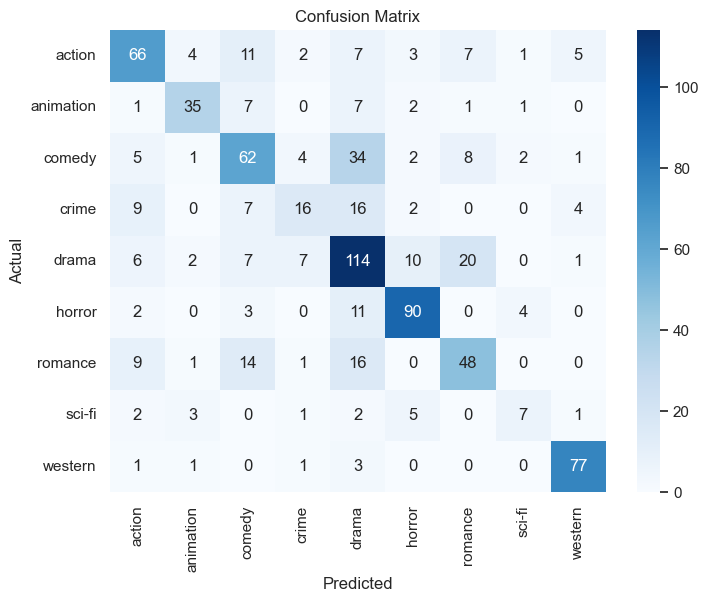

In [55]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, decoded_class_names)

### Scenario 2: SVM w/o feature selection

In [56]:
text_pipeline_2 = make_union(
    make_pipeline(
        ColumnSelector("title", drop_axis=True),
        TfidfVectorizer(),
    ),
    make_pipeline(
        ColumnSelector("description", drop_axis=True),
        TfidfVectorizer(),
    ),
    make_pipeline(SelectCols("region"), SimilarityEncoder()),
    make_pipeline(SelectCols("from"), OneHotEncoder(sparse_output=False)),
    make_pipeline(SelectCols("encoded_director")),
)

pipeline_2 = make_pipeline(text_pipeline_2, SVC())
pipeline_2

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('columnselector',
                                                                  ColumnSelector(cols='title',
                                                                                 drop_axis=True)),
                                                                 ('tfidfvectorizer',
                                                                  TfidfVectorizer())])),
                                                ('pipeline-2',
                                                 Pipeline(steps=[('columnselector',
                                                                  ColumnSelector(cols='description',
                                                                                 drop_axis=True)),
                                                                 ('tfidfvectorizer',
                                                                  TfidfVectorizer())])),
                                                ('pipeline-3',
                                                 Pipeline(steps=[('selectcols',
                                                                  SelectCols(cols='region')),
                                                                 ('similarityencoder',
                                                                  SimilarityEncoder())])),
                                                ('pipeline-4',
                                                 Pipeline(steps=[('selectcols',
                                                                  SelectCols(cols='from')),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(sparse_output=False))])),
                                                ('pipeline-5',
                                                 Pipeline(steps=[('selectcols',
                                                                  SelectCols(cols='encoded_director'))]))])),
                ('svc', SVC())])

In [57]:
param_distributions = {
    "svc__C": np.logspace(-3, 3, 100),
    "svc__kernel": ["poly", "sigmoid", "rbf", "linear"],
    "svc__gamma": ["scale", "auto"] + list(np.logspace(-4, 1, 100)),
    "svc__degree": np.arange(2, 6),
    "svc__coef0": np.linspace(-1, 1, 100),
}

In [ ]:
random_search_2 = RandomizedSearchCV(
    pipeline_2,
    param_distributions=param_distributions,
    n_iter=50,
    cv=4,
    scoring="accuracy",
    random_state=42,
    verbose=4,
    error_score="raise",
)
random_search_2.fit(X_train, y_train)

In [ ]:
best_params = random_search_2.best_params_
best_score = random_search_2.best_score_
best_model = random_search_2.best_estimator_

print("\nBest Parameters:", best_params)
print("\nBest Score:", best_score)

In [58]:
best_params = {
    "svc__kernel": "sigmoid",
    "svc__gamma": 0.05994842503189409,
    "svc__degree": 3,
    "svc__coef0": 0.010101010101010166,
    "svc__C": 46.41588833612782,
}

# Best Score: 0.6633383186639723

In [59]:
pipeline_2.set_params(**best_params)
pipeline_2.fit(X_train, y_train)
y_pred = pipeline_2.predict(X_test)

In [60]:
accuracy_score(y_test, y_pred)
# Test Accuracy: 0.6824408468244084

0.6824408468244084

In [61]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

      action       0.67      0.69      0.68       106
   animation       0.82      0.78      0.80        54
      comedy       0.58      0.61      0.60       119
       crime       0.53      0.33      0.41        54
       drama       0.60      0.70      0.65       167
      horror       0.82      0.83      0.82       110
     romance       0.63      0.56      0.60        89
      sci-fi       0.46      0.29      0.35        21
     western       0.91      0.94      0.92        83

    accuracy                           0.68       803
   macro avg       0.67      0.64      0.65       803
weighted avg       0.68      0.68      0.68       803



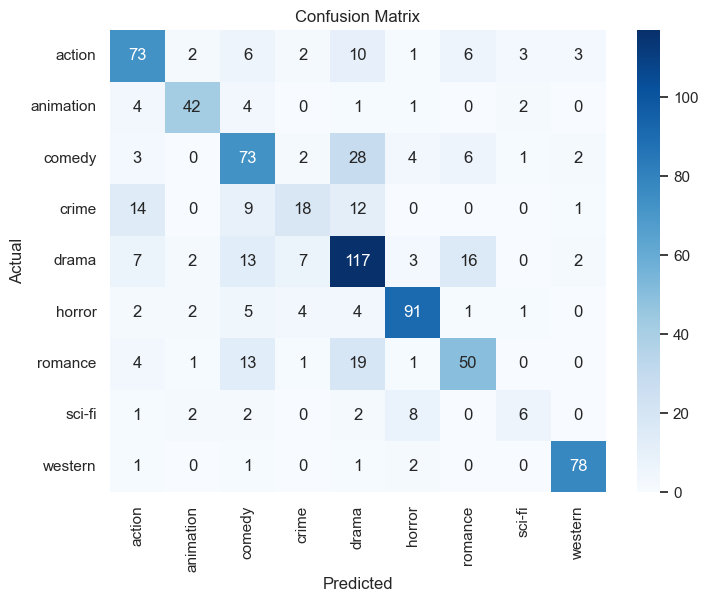

In [62]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, decoded_class_names)

### Scenario 3: SVM w/ Feature Selection

In [63]:
text_pipeline_3 = make_union(
    make_pipeline(
        ColumnSelector("title", drop_axis=True),
        TfidfVectorizer(ngram_range=(2, 4)),
    ),
    make_pipeline(
        ColumnSelector("selected_description", drop_axis=True),
        TfidfVectorizer(),
    ),
    make_pipeline(SelectCols("region"), SimilarityEncoder()),
    make_pipeline(SelectCols("from"), OneHotEncoder(sparse_output=False)),
    make_pipeline(SelectCols("encoded_director")),
)

pipeline_3 = make_pipeline(text_pipeline_3, SVC())
pipeline_3

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('columnselector',
                                                                  ColumnSelector(cols='title',
                                                                                 drop_axis=True)),
                                                                 ('tfidfvectorizer',
                                                                  TfidfVectorizer(ngram_range=(2,
                                                                                               4)))])),
                                                ('pipeline-2',
                                                 Pipeline(steps=[('columnselector',
                                                                  ColumnSelector(cols='selected_description',
                                                                                 drop_axis=True)),
                                                                 ('tfidfvectorizer',
                                                                  TfidfVect...())])),
                                                ('pipeline-3',
                                                 Pipeline(steps=[('selectcols',
                                                                  SelectCols(cols='region')),
                                                                 ('similarityencoder',
                                                                  SimilarityEncoder())])),
                                                ('pipeline-4',
                                                 Pipeline(steps=[('selectcols',
                                                                  SelectCols(cols='from')),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(sparse_output=False))])),
                                                ('pipeline-5',
                                                 Pipeline(steps=[('selectcols',
                                                                  SelectCols(cols='encoded_director'))]))])),
                ('svc', SVC())])

In [ ]:
random_search_3 = RandomizedSearchCV(
    pipeline_3,
    param_distributions=param_distributions,
    n_iter=50,
    cv=4,
    scoring="accuracy",
    random_state=42,
    verbose=4,
    error_score="raise",
)
random_search_3.fit(X_train, y_train)

In [ ]:
best_params = random_search_3.best_params_
best_score = random_search_3.best_score_
best_model = random_search_3.best_estimator_

print("\nBest Parameters:", best_params)
print("\nBest Score:", best_score)

In [64]:
best_params = {
    "svc__kernel": "poly",
    "svc__gamma": 0.002595024211399737,
    "svc__degree": 2,
    "svc__coef0": 0.8787878787878789,
    "svc__C": 376.49358067924715,
}

# Best Score: 0.6580756214260708

In [65]:
pipeline_3.set_params(**best_params)
pipeline_3.fit(X_train, y_train)
y_pred = pipeline_3.predict(X_test)

In [66]:
accuracy_score(y_test, y_pred)
# Test Accuracy: 0.6674968866749689

0.6674968866749689

In [67]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

      action       0.61      0.70      0.65       106
   animation       0.85      0.72      0.78        54
      comedy       0.62      0.55      0.59       119
       crime       0.55      0.31      0.40        54
       drama       0.53      0.71      0.61       167
      horror       0.82      0.83      0.82       110
     romance       0.65      0.51      0.57        89
      sci-fi       0.82      0.43      0.56        21
     western       0.91      0.93      0.92        83

    accuracy                           0.67       803
   macro avg       0.71      0.63      0.66       803
weighted avg       0.68      0.67      0.66       803



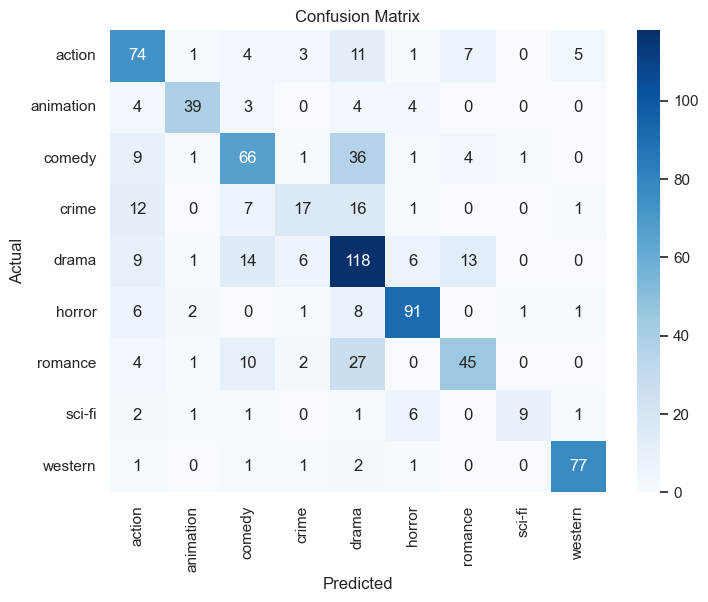

In [68]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, decoded_class_names)

### Modelling with Embeddings

In [50]:
X_train = embedding_train_df.drop("genre", axis=1)
y_train = embedding_train_df["genre"]

In [52]:
X_test = embedding_test_df.drop("genre", axis=1)
y_test = embedding_test_df["genre"]

### Scenario 4: SVM w/ Embeddings  

In [71]:
param_distributions = {
    "C": np.logspace(-3, 3, 100),
    "kernel": ["poly", "sigmoid"],
    "gamma": ["scale", "auto"] + list(np.logspace(-4, 1, 100)),
    "degree": np.arange(2, 6),
    "coef0": np.linspace(-1, 1, 100),
    "class_weight": ["balanced", None],
}

In [ ]:
random_search_4 = RandomizedSearchCV(
    SVC(),
    param_distributions=param_distributions,
    n_iter=50,
    scoring="accuracy",
    cv=4,
    verbose=4,
    random_state=42,
    n_jobs=-1,
)

random_search_4.fit(X_train, y_train)

In [ ]:
best_params = random_search_4.best_params_
best_score = random_search_4.best_score_
best_model = random_search_4.best_estimator_

print("\nBest Parameters:", best_params)
print("\nBest Score:", best_score)

In [72]:
best_params = {
    "kernel": "poly",
    "gamma": 7.054802310718645,
    "degree": 3,
    "coef0": -0.050505050505050386,
    "class_weight": None,
    "C": 0.0026560877829466868,
}

# Best Score: 0.6867000556483027

In [73]:
svc = SVC()
svc.set_params(**best_params)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [53]:
accuracy_score(y_test, y_pred)
# Test Accuracy: 0.676214196762142

0.6749688667496887

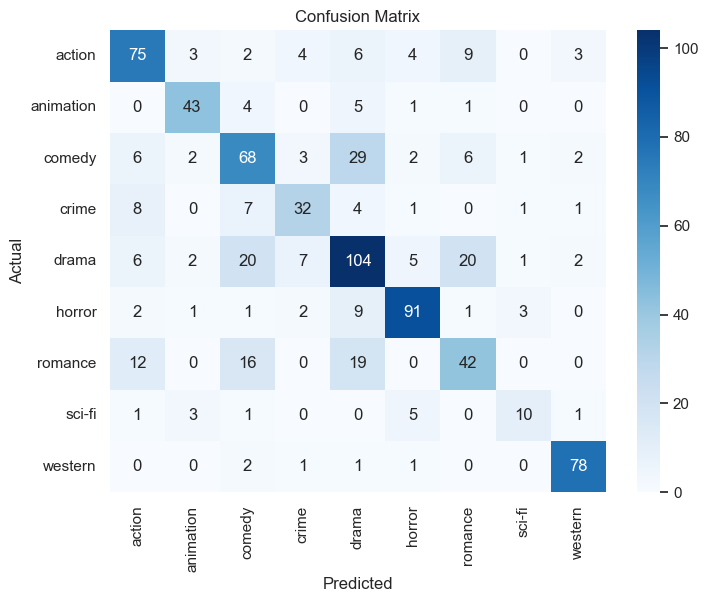

In [75]:
cm = cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, decoded_class_names)

### Scenario 5: HistGradientBoosting w/ Embeddings

In [43]:
param_distributions = {
    "learning_rate": np.logspace(-3, 0, 100),
    "max_iter": np.arange(100, 500, 50),
    "max_depth": np.arange(3, 15),
    "min_samples_leaf": np.arange(1, 51, 5),
    "max_leaf_nodes": np.arange(10, 301, 10),
    "l2_regularization": np.logspace(-4, 0, 100),
    "scoring": ["accuracy"],
}

In [ ]:
random_search_5 = RandomizedSearchCV(
    HistGradientBoostingClassifier(),
    param_distributions=param_distributions,
    n_iter=50,
    scoring="accuracy",
    cv=4,
    verbose=4,
    random_state=42,
    n_jobs=-1,
)

random_search_5.fit(X_train, y_train)

In [ ]:
best_params = random_search_5.best_params_
best_score = random_search_5.best_score_
best_model = random_search_5.best_estimator_

print("\nBest Parameters:", best_params)
print("\nBest Score:", best_score)

In [44]:
best_params = {
    "scoring": "accuracy",
    "min_samples_leaf": 46,
    "max_leaf_nodes": 50,
    "max_iter": 250,
    "max_depth": 12,
    "learning_rate": 0.12328467394420659,
    "l2_regularization": 0.0016297508346206436,
}

# Best Score: 0.6687534780189204

In [45]:
best_params = {
    "scoring": "accuracy",
    "min_samples_leaf": 46,
    "max_leaf_nodes": 50,
    "max_iter": 250,
    "max_depth": 12,
    "learning_rate": 0.12328467394420659,
    "l2_regularization": 0.0016297508346206436,
}


hgb = HistGradientBoostingClassifier()
hgb.set_params(**best_params)
hgb.fit(X_train, y_train)
y_pred = hgb.predict(X_test)

In [46]:
accuracy_score(y_test, y_pred)
# Test Accuracy: 0.6749688667496887

0.6749688667496887

In [47]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

      action       0.69      0.69      0.69       106
   animation       0.76      0.72      0.74        54
      comedy       0.59      0.55      0.57       119
       crime       0.61      0.61      0.61        54
       drama       0.57      0.66      0.61       167
      horror       0.80      0.81      0.81       110
     romance       0.59      0.51      0.55        89
      sci-fi       0.83      0.48      0.61        21
     western       0.90      0.93      0.91        83

    accuracy                           0.67       803
   macro avg       0.70      0.66      0.68       803
weighted avg       0.68      0.67      0.67       803



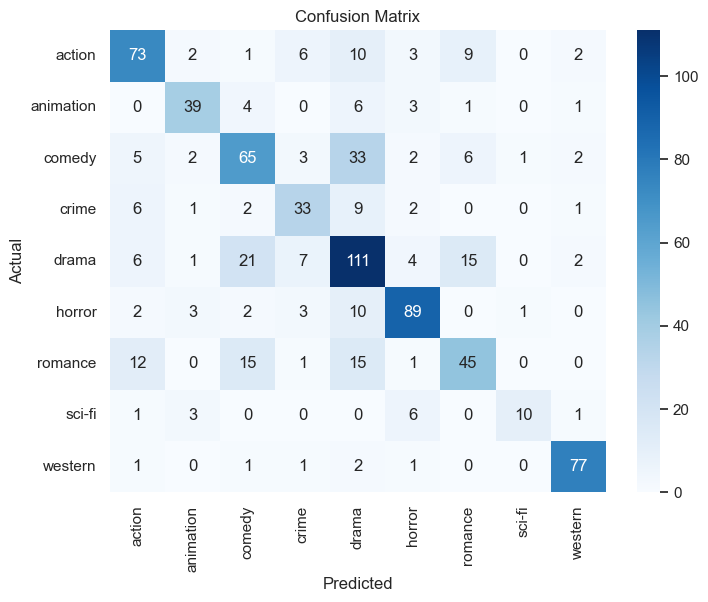

In [48]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, decoded_class_names)

In [56]:
y_proba = hgb.predict_proba(X_test)
max_proba = np.max(y_proba, axis=1)
misclassified = y_test != y_pred

df_errors = pd.DataFrame(
    {
        "true_label": label_encoder.inverse_transform(y_test),
        "predicted_label": label_encoder.inverse_transform(y_pred),
        "max_proba": max_proba,
        "text": test_df["description"],  # Assuming X_test contains the corresponding descriptions
    }
)

df_misclassified = df_errors[misclassified]
df_misclassified_sorted = df_misclassified.sort_values(by="max_proba", ascending=False)
df_misclassified_sorted.head()

,true_label,predicted_label,max_proba,text
712,drama,animation,1.000000,the movie begin with willy at home sick and be...
676,sci-fi,horror,0.999994,dr robert rack hansen a veterinarian in rural ...
53,crime,action,0.999989,the film open at canyon park where narcotic co...
611,comedy,drama,0.999909,a mother and wife stricken with memory loss al...
632,comedy,horror,0.999876,the story start with anna matthew tabu explain...


genre
False    2074.202952
True     1710.478927
Name: description_length, dtype: float64


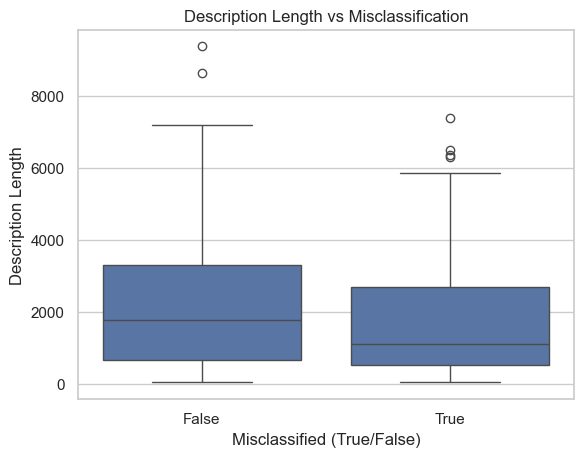

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

df_errors["description_length"] = df_errors["text"].apply(len)
print(df_errors.groupby(misclassified)["description_length"].mean())

sns.boxplot(x=misclassified, y="description_length", data=df_errors)
plt.title("Description Length vs Misclassification")
plt.xlabel("Misclassified (True/False)")
plt.ylabel("Description Length")
plt.show()


c:\Users\vasco\repos\Natural-Language\venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


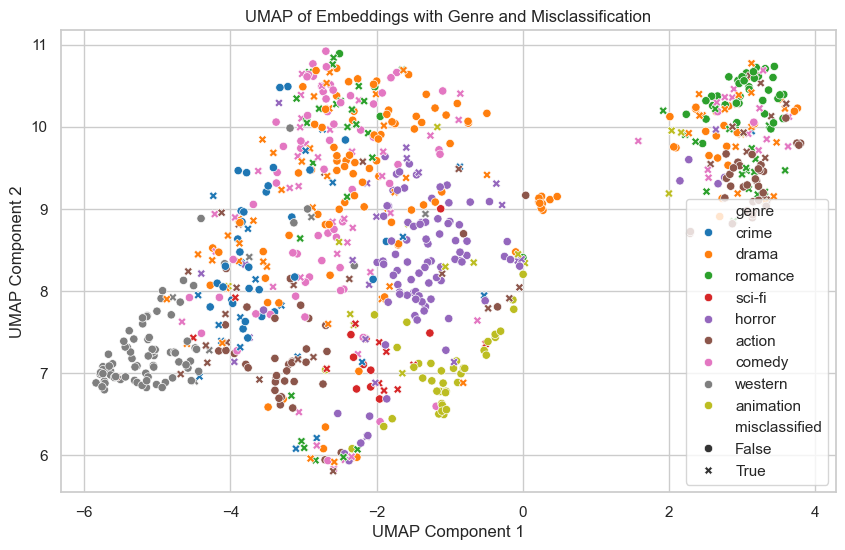

In [73]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_model.fit_transform(embedding_test_df.drop("genre", inplace=False, axis=1))

# Create DataFrame with UMAP results, misclassification, and genre info
umap_df = pd.DataFrame(umap_embeddings, columns=["UMAP1", "UMAP2"])
umap_df["misclassified"] = y_test != y_pred
umap_df["genre"] = label_encoder.inverse_transform(df_errors["genre"])

# Plot UMAP results with genre color and misclassification marker
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="UMAP1",
    y="UMAP2",
    hue="genre",
    style="misclassified",
    markers={False: "o", True: "X"},
    data=umap_df,
    palette="tab10",
)
plt.title("UMAP of Embeddings with Genre and Misclassification")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

true_label
action       33
animation    15
comedy       54
crime        21
drama        56
horror       21
romance      44
sci-fi       11
western       6
dtype: int64


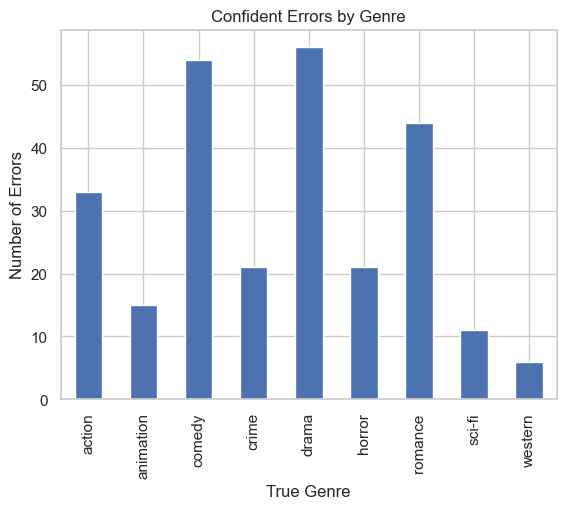

In [59]:
df_errors["genre"] = y_test

confident_errors_by_genre = df_misclassified_sorted.groupby("true_label").size()
print(confident_errors_by_genre)

confident_errors_by_genre.plot(kind="bar")
plt.title("Confident Errors by Genre")
plt.xlabel("True Genre")
plt.ylabel("Number of Errors")
plt.show()

# Predict Test Set

In [7]:
path_test = "data/raw/test_no_labels.txt"
columns_test = ["title", "from", "director", "description"]

df_no_labels_test = read_data(path_test, columns_test)
df_no_labels_test.head(3)

,title,from,director,description
0,Bava Nachadu,Telugu,KS Ravikumar,Ajay (Nagarjuna Akkineni) is an adman (directo...
1,Quick,South_Korean,Unknown,"Seoul, 2004. A group of bikers are joy-riding ..."
2,Doraemon: Nobita's Great Battle of the Mermaid...,Japanese,Unknown,"The film opens with a sunken ship, in which a ..."


In [9]:
path_train = "data/raw/train.txt"
columns = ["title", "from", "genre", "director", "description"]

df = read_data(path_train, columns)
df.head(3)

,title,from,genre,director,description
0,Ela Cheppanu,Telugu,romance,Ramana,Sekhar (Tarun) is a graduate from IIM and work...
1,A Nightmare on Elm Street,American,horror,Samuel Bayer,Kris Fowles (Katie Cassidy) goes to the Spring...
2,American Gothic,American,horror,John Hough,Cynthia is traumatized by the death of her bab...


In [86]:
output_path = "data/processed/processed_embeddings_full.csv"
process_and_save_in_chunks(df, "description", model, chunk_size=300, output_path=output_path)

8041

In [ ]:
output_path = "data/processed/processed_embeddings_no_labels_test.csv"
process_and_save_in_chunks(df_no_labels_test, "description", model, chunk_size=300, output_path=output_path)

In [12]:
input_path = "data/processed/processed_embeddings_full.csv"
df_train_full = pd.read_csv(input_path)
df_train_full = pd.concat([df["genre"], df_train_full], axis=1)
df_train_full.drop_duplicates(inplace=True)
df_train_full.reset_index(drop=True, inplace=True)
df_train_full.head(3)

,genre,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_375,embedding_376,embedding_377,embedding_378,embedding_379,embedding_380,embedding_381,embedding_382,embedding_383,embedding_384
0,romance,-0.041982,0.009745,-0.015205,-0.051385,0.004120,0.003775,0.124440,0.011798,-0.011639,...,0.006965,-0.031302,-0.053417,-0.007111,-0.032276,-0.013841,-0.034195,0.006292,0.014315,0.050230
1,horror,-0.037165,0.009819,0.010510,0.022792,0.026812,0.049035,0.066255,0.010202,0.002698,...,0.057392,-0.030134,-0.002473,-0.008530,-0.015487,-0.037878,-0.026629,-0.005880,0.045985,0.016462
2,horror,-0.021995,0.002554,-0.000197,-0.000416,0.055480,0.056321,0.072085,-0.016350,0.009560,...,0.029795,-0.040127,-0.007007,-0.002363,-0.006360,-0.020129,-0.039561,0.001548,0.039576,0.020360


In [13]:
input_path = "data/processed/processed_embeddings_no_labels_test.csv"
df_no_labels_embeddings = pd.read_csv(input_path)
df_no_labels_embeddings.head(3)

,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,...,embedding_375,embedding_376,embedding_377,embedding_378,embedding_379,embedding_380,embedding_381,embedding_382,embedding_383,embedding_384
0,-0.022407,0.021707,-0.019075,0.001037,-0.021242,0.037736,0.100590,-0.006982,-0.010001,-0.050149,...,-0.003385,-0.044730,0.011717,-0.031537,0.001381,-0.006788,-0.023878,0.010053,-0.008352,0.026779
1,-0.062447,0.045382,0.048621,-0.064936,0.042378,0.048507,0.085783,0.009426,-0.023392,-0.017873,...,0.067204,-0.034692,-0.010551,-0.036687,0.008993,0.016287,-0.065046,0.000634,0.030815,0.045870
2,-0.059761,0.005166,0.033768,-0.002652,0.027914,0.021735,0.088471,0.057611,-0.018964,0.020268,...,0.037787,-0.066673,-0.024675,-0.009438,-0.010807,0.027690,-0.042446,0.016171,0.003533,0.023038


In [14]:
label_encoder = LabelEncoder().fit(df_train_full["genre"])
X_train = df_train_full.drop("genre", axis=1)
y_train = label_encoder.transform(df_train_full["genre"])

In [15]:
train_description = df["description"].dropna().unique()
test_description = df_no_labels_test["description"].dropna().unique()

overlapping_descriptions = set(train_description).intersection(set(test_description))
print(f"{len(overlapping_descriptions)} overlapping descriptions found.")

10 overlapping descriptions found.


In [16]:
rule_based_dict = df[df["description"].isin(overlapping_descriptions)].set_index("description")["genre"].to_dict()


def rule_based_prediction(description):
    if description in rule_based_dict:
        return rule_based_dict[description]
    return None


df_no_labels_test["rule_based_prediction"] = df_no_labels_test["description"].apply(rule_based_prediction)

In [17]:
best_params = {
    "scoring": "accuracy",
    "min_samples_leaf": 46,
    "max_leaf_nodes": 50,
    "max_iter": 250,
    "max_depth": 12,
    "learning_rate": 0.12328467394420659,
    "l2_regularization": 0.0016297508346206436,
}

hgb = HistGradientBoostingClassifier()
hgb.set_params(**best_params)
hgb.fit(X_train, y_train)
results = hgb.predict(df_no_labels_embeddings)

In [18]:
decoded_results = label_encoder.inverse_transform(results)

In [21]:
pd.Series(decoded_results).value_counts(normalize=True)

drama        0.2150
horror       0.1625
action       0.1550
comedy       0.1525
romance      0.1050
western      0.0875
animation    0.0700
crime        0.0400
sci-fi       0.0125
Name: proportion, dtype: float64

In [22]:
pd.Series(df["genre"]).value_counts(normalize=True)

genre
drama        0.208432
comedy       0.148365
horror       0.137794
action       0.131700
romance      0.110185
western      0.103097
crime        0.067280
animation    0.066534
sci-fi       0.026614
Name: proportion, dtype: float64

In [20]:
df_no_labels_test[pd.Series(decoded_results) == df_no_labels_test["rule_based_prediction"]]

,title,from,director,description,rule_based_prediction
46,Watchers,American,Unknown,An explosion occurs in a classified research l...,horror
99,The Wasp Woman,American,Roger Corman,"In Hill's prologue, a scientist, Dr. Eric Zint...",sci-fi
112,The Shooting,American,Monte Hellman,"Willet Gashade (Oates), a former bounty hunter...",western
134,Hellbound: Hellraiser II,American,Tony Randel,We see the origin of Pinhead as a British mili...,horror
188,Kochadaiiyaan 2D,Punjabi,Unknown,"A young boy named Rana, who hails from the kin...",action
266,Prem Rog,Bollywood,Raj Kapoor,Devdhar (Rishi Kapoor) is a poor orphan who in...,romance
285,The House Next Door,Bollywood,Milind Rau,The film opens with an ancient Chinese mother ...,horror
290,Bronco Bullfrog,British,Barney Platts-Mills,The film follows the fortunes of a 17-year-old...,drama
319,Puella Magi Madoka Magica (Part 2),Japanese,Akiyuki Shinbo,"In the fictional city of Mitakihara, Japan, a ...",animation
386,Moner Manush (film),Bengali,Goutam Ghose,Rabindranath Tagore's elder brother Jyotirindr...,drama


In [23]:
np.savetxt("data/processed/predictions.txt", decoded_results, fmt="%s")